# **Setup**

1. Dependencies Installieren

In [ ]:
%pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

2. Package importieren

In [1]:
#Packung für das Sammeln durch den Webcam
import os, time, uuid, cv2
from pathlib import Path

In [2]:
#Packung für Bilderverarbeitung
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Packung für die Ablumentation und die Bildung der Data-Pipeline
import albumentations as alb

In [4]:
#Packung für das Modelbau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

# Limit GPU Memory Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Getting the right PATH

# Bilder labeln



```
!labelme
```

Labelme öffnen, um Ausgangsdaten mit Labels zu versehen, dort wo Gesichter zu sehen sind (nach Akzepentanzkritierien PROJ-71)

Rechteck um das Gesicht, wenn kein Gesicht vorhanden Datei ignorieren

Labels als json in den labels Ordner übertragen

# **3. Die gesamte Datenmenge in kleineren Gruppen aufteilen**

Trennung der data/images Ordner in 3 kleineren Ordnern
```
#training_set
for x in range(int(len(l)*0.7)+1):
  file = l[x]
  EX_PATH = os.path.join("data","images",file)
  NEW_PATH = os.path.join("data","train","images",file)
  os.replace(EX_PATH,NEW_PATH)


#testing_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','images',file)
  NEW_PATH = os.path.join('data','test','images',file)
  os.replace(EX_PATH,NEW_PATH)

#validation_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','test','images',file)
  NEW_PATH = os.path.join('data','val','images',file)
  os.replace(EX_PATH,NEW_PATH)
```



Die passende Label für jedes Bildes in der richtige Ordner anordnen


```
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0]+'.json'
    EX_PATH = os.path.join('data','labels',filename)
    if os.path.exists(EX_PATH):
      NEW_PATH = os.path.join('data',folder,'labels',filename)
      os.replace(EX_PATH,NEW_PATH)
```



In [ ]:
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0]+'.json'
    EX_PATH = os.path.join('data','labels',filename)
    if os.path.exists(EX_PATH):
      NEW_PATH = os.path.join('data',folder,'labels',filename)
      os.replace(EX_PATH,NEW_PATH)

Image in eine tf data pipeline laden (Beispiel)

In [8]:
images = tf.data.Dataset.list_files(os.path.join('data/train/images/*.jpg'))

In [9]:
images.as_numpy_iterator().next()

b'data\\train\\images\\image86.jpg'

In [10]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(120,120))
    img = img/255
    return img

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

array([[[0.7411765 , 0.7254902 , 0.6901961 ],
        [0.7456086 , 0.72992235, 0.69462824],
        [0.74996597, 0.7342797 , 0.6989856 ],
        ...,
        [0.03153603, 0.03529412, 0.04313726],
        [0.03137255, 0.03137255, 0.03921569],
        [0.02826797, 0.02826797, 0.03611111]],

       [[0.7490196 , 0.73333335, 0.69803923],
        [0.7523897 , 0.73670346, 0.70140934],
        [0.7554943 , 0.739808  , 0.7045139 ],
        ...,
        [0.0354576 , 0.03921569, 0.04705882],
        [0.0377451 , 0.0377451 , 0.04558824],
        [0.03529412, 0.03529412, 0.04313726]],

       [[0.7607843 , 0.74509805, 0.70980394],
        [0.7607843 , 0.74509805, 0.70980394],
        [0.76862746, 0.7529412 , 0.7176471 ],
        ...,
        [0.03938597, 0.04314407, 0.0509872 ],
        [0.04313726, 0.04313726, 0.05098039],
        [0.04016219, 0.04016219, 0.04800532]],

       ...,

       [[0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0

In [13]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

Image visualisieren 

In [14]:
images_generator = images.batch(4).as_numpy_iterator()

In [15]:
plot_images = images_generator.next()

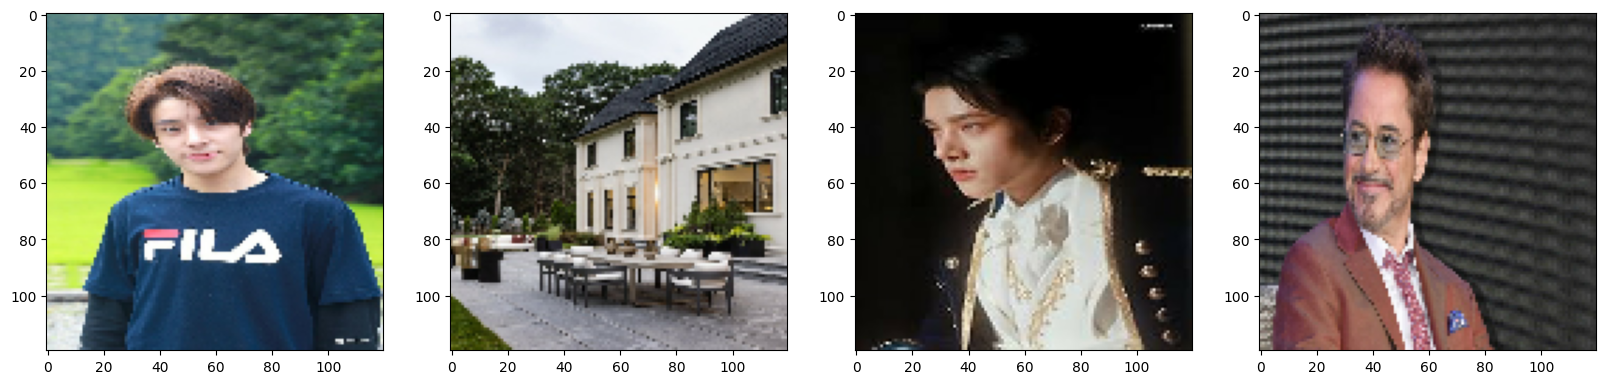

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# **4. Albumentation Setting für die Augmentatition den Bildern aufstellen**

In [79]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)], 
                        bbox_params= alb.BboxParams(format="albumentations",label_fields=["class_labels"]))
#

Laden eines Beispielbilds

In [80]:
image_path = "image13"

In [81]:
img = cv2.imread(os.path.join('data','train','images',image_path+".jpg"))

In [82]:
size= img.shape
print(size)

(650, 650, 3)


In [83]:
with open(os.path.join('data','train','labels',image_path+'.json'),'r') as f:
  label = json.load(f)

In [84]:
label['shapes'][0]['points']

[[174.48275862068965, 39.0], [535.8620689655172, 398.3103448275862]]

Koordinaten Extrahieren und Maßstab ändern

In [85]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [86]:
coords

[174.48275862068965, 39.0, 535.8620689655172, 398.3103448275862]

In [87]:
coords = list(np.divide(coords,[650,650,650,650]))

In [88]:
coords

[0.26843501326259944, 0.06, 0.8244031830238726, 0.6127851458885942]

Augmentation implimentieren

In [93]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [94]:
augmented['bboxes'][0]


(0.0, 0.4881992337164749, 0.6944827586206896, 1.0)

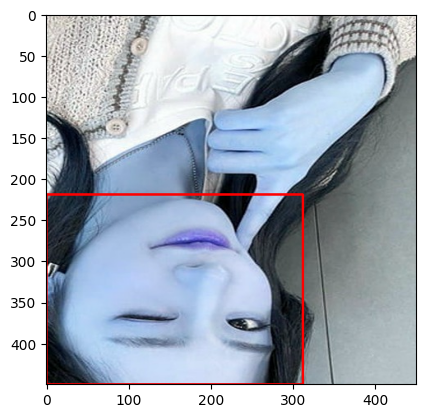

In [95]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

Aug-data Ordner herstellen

In [96]:
for path in ['train','test','val']:
  for folder in ['images','labels']:
   PATH = os.path.join('aug_data',path,folder)
   os.makedirs(PATH)

# **5. Augmentation Pipeline durchführen**

In [97]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        size = img.shape

        coords = [0,0,0,0]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6238726790450928, 0.5544297082228117, 0.19628647214854114, 0.08015915119363395, 'face'].
x_max is less than or equal to x_min for bbox [0.5920424403183026, 0.5544297082228117, 0.10079575596816977, 0.05893899204244032, 'face'].
x_max is less than or equal to x_min for bbox [0.6153846153846154, 0.3931564986737401, 0.38196286472148544, 0.13320954907161806, 'face'].
x_max is less than or equal to x_min for bbox [0.6206896551724138, 0.08228116710875331, 0.35862068965517246, 0.42180371352785145, 'face'].
x_max is less than or equal to x_min for bbox [0.6992042440318302, 0.48864721485411144, 0.26631299734748015, 0.07379310344827586, 'face'].
x_max is less than or equal to x_min for bbox [0.5941644562334218, 0.2520424403183024, 0.3618037135278515, 0.045145888594164456, 'face'].
x_max is less than or equal to x_min for bbox [0.6058355437665783, 0.16928381962864722, 0.3925729442970823, 0.031352785145888594, 'face'].
y_max is less than or equal to 

## **6.Die Augmented Bildern zu eine Tensorflow Dataset laden**

In [98]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle= False)
train_images = train_images.map(load_image)

In [99]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle= False)
test_images = test_images.map(load_image)

In [100]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle= False)
val_images = val_images.map(load_image)

In [101]:
train_images.as_numpy_iterator().next()

array([[[0.79607844, 0.8223652 , 0.8136029 ],
        [0.8408701 , 0.8643995 , 0.85655636],
        [0.875     , 0.89362746, 0.8882353 ],
        ...,
        [0.2917892 , 0.28394607, 0.2329657 ],
        [0.29436275, 0.27867648, 0.2329044 ],
        [0.36893383, 0.35631126, 0.30919117]],

       [[0.78039217, 0.811826  , 0.80919117],
        [0.82757354, 0.8523897 , 0.85110295],
        [0.8613971 , 0.8849265 , 0.87708336],
        ...,
        [0.25349265, 0.23780638, 0.19123775],
        [0.17536765, 0.14791666, 0.10870098],
        [0.13756128, 0.11452206, 0.07383578]],

       [[0.7710784 , 0.8063725 , 0.80245095],
        [0.8088848 , 0.8441789 , 0.8324142 ],
        [0.8594363 , 0.8947304 , 0.8829657 ],
        ...,
        [0.1896446 , 0.17395833, 0.13082108],
        [0.20306373, 0.17561275, 0.13639706],
        [0.21421568, 0.1985294 , 0.15539216]],

       ...,

       [[0.4764706 , 0.5245098 , 0.49068627],
        [0.47457108, 0.5216299 , 0.48241422],
        [0.4867647 , 0

Labels vorbereiten

In [102]:
def load_labels(label_path):
  with open(label_path.numpy(),'r', encoding = "utf-8") as f:
    label = json.load(f)
  
  return [label['class']],label['bbox']

In [103]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle= False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [104]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle= False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [105]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle= False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [106]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2854, 0.4937, 0.7144, 1.    ], dtype=float16))

# **7. Combine Image and Label Sampels**

7.1 Check Partition Lengths

In [107]:
len(train_images), len(train_labels), len(test_images), len(test_labels),len(val_images), len(val_labels)

(1260, 1260, 540, 540, 180, 180)

7.2 Create Final Dataset (Image/Label)

In [108]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [109]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [110]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [180]:
train.as_numpy_iterator().next()[0]

array([[[[0.7216299 , 0.4201593 , 0.40900734],
         [0.7207721 , 0.39724264, 0.38125   ],
         [0.73970586, 0.3889093 , 0.36090687],
         ...,
         [0.35796568, 0.23688726, 0.22561274],
         [0.2944853 , 0.19252451, 0.20330882],
         [0.27542892, 0.19552696, 0.23480392]],

        [[0.6214461 , 0.37340686, 0.36458334],
         [0.6976716 , 0.42806372, 0.4083946 ],
         [0.75582105, 0.44197303, 0.42444852],
         ...,
         [0.42009804, 0.29607844, 0.3004902 ],
         [0.26666668, 0.16519608, 0.19987746],
         [0.27450982, 0.18921569, 0.2547794 ]],

        [[0.4509804 , 0.28382352, 0.26911765],
         [0.5672794 , 0.36335784, 0.3466912 ],
         [0.6940564 , 0.44074756, 0.40680146],
         ...,
         [0.39454657, 0.2773897 , 0.27751225],
         [0.2831495 , 0.1807598 , 0.2297794 ],
         [0.3004902 , 0.21090686, 0.28903186]],

        ...,

        [[1.        , 0.9254902 , 1.        ],
         [1.        , 0.9254902 , 1.        ]

7.3 View Images and Annotations

In [112]:
data_samples = train.as_numpy_iterator()

In [115]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


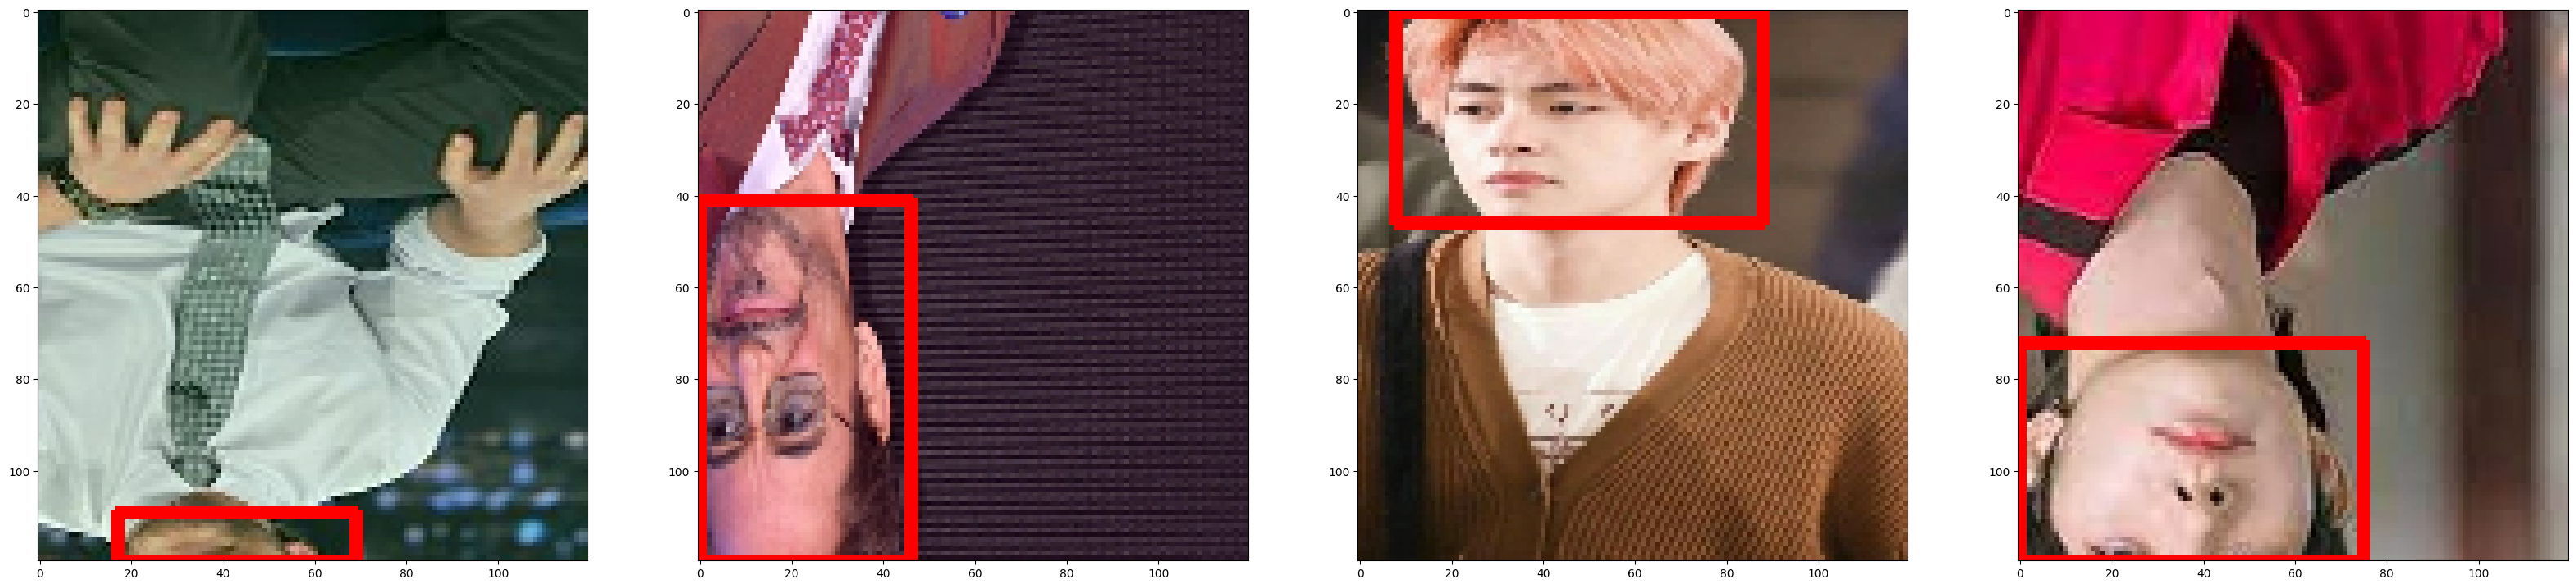

In [116]:
fig, ax = plt.subplots(ncols=4, figsize=(40, 40))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# **8. Aufbauen des Deep Learning-Modells**

### 8.1 Base Network sowie Layers importieren und VGG16 installieren

In [117]:
vgg = VGG16(include_top=False)

In [118]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.2 Eine Instanz des Neural Networks bauen

In [119]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.3 Testen des Neural Networks

In [120]:
facetracker = build_model()

In [121]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [122]:
X, y = train.as_numpy_iterator().next()

In [123]:
X.shape

(8, 120, 120, 3)

In [124]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 9s 9s/step


In [125]:
classes, coords

(array([[0.6466571 ],
        [0.8244845 ],
        [0.7087571 ],
        [0.7806293 ],
        [0.8633257 ],
        [0.74536026],
        [0.7599967 ],
        [0.79270655]], dtype=float32),
 array([[0.5811078 , 0.314383  , 0.36214688, 0.47405332],
        [0.67593133, 0.39688292, 0.43829277, 0.45081642],
        [0.6783888 , 0.36761183, 0.48968685, 0.5344836 ],
        [0.70361847, 0.3607897 , 0.41651067, 0.530193  ],
        [0.66349685, 0.32506943, 0.33467916, 0.56286865],
        [0.65247595, 0.35293645, 0.4497424 , 0.47543105],
        [0.6493162 , 0.43155983, 0.45583898, 0.54677254],
        [0.60245705, 0.3791747 , 0.39183736, 0.53764296]], dtype=float32))

# **9.Define Losses and Optimizer**

## 9.1 Define Optimizer

In [126]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/ batches_per_epoch

In [127]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Create Localization Loss and Classification Loss

In [128]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [129]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics

In [130]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=10.780103>

In [131]:
classloss(y[0],classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.27105328>

In [132]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=10.780103>

# **10.Train Neural Network**

## 10.1 Create Custom Model Class

In [134]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [135]:
model = FaceTracker(facetracker)

In [136]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [137]:
logdir='logs'

In [138]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [140]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
158/158 [==============================] - 29s 163ms/step - total_loss: 0.0087 - class_loss: 1.5451e-04 - regress_loss: 0.0086 - val_total_loss: 0.2342 - val_class_loss: 0.0014 - val_regress_loss: 0.2335
Epoch 2/10
158/158 [==============================] - 29s 163ms/step - total_loss: 0.0071 - class_loss: 1.1618e-04 - regress_loss: 0.0071 - val_total_loss: 0.0478 - val_class_loss: 1.0623e-04 - val_regress_loss: 0.0478
Epoch 3/10
158/158 [==============================] - 29s 164ms/step - total_loss: 0.0059 - class_loss: 7.5935e-05 - regress_loss: 0.0059 - val_total_loss: 0.6465 - val_class_loss: 0.5879 - val_regress_loss: 0.3525
Epoch 4/10
158/158 [==============================] - 28s 163ms/step - total_loss: 0.0058 - class_loss: 7.7526e-05 - regress_loss: 0.0057 - val_total_loss: 0.0594 - val_class_loss: 9.4647e-05 - val_regress_loss: 0.0593
Epoch 5/10
158/158 [==============================] - 28s 164ms/step - total_loss: 0.0046 - class_loss: 5.9021e-05 - regress_loss: 0

## 10.3 Plot Performance

In [141]:
hist.history

{'total_loss': [0.003891855012625456,
  0.0038554519414901733,
  0.003117547370493412,
  0.0044918367639184,
  0.0031963661313056946,
  0.0014938150998204947,
  0.0010635467479005456,
  0.0023041232489049435,
  0.0012431753566488624,
  0.001879651565104723],
 'class_loss': [1.788139627478813e-07,
  3.981907502748072e-05,
  7.215686491690576e-05,
  2.0861631355728605e-07,
  6.735399892932037e-06,
  2.452819717291277e-05,
  4.261750291334465e-06,
  1.490116545710407e-07,
  2.980233944072097e-07,
  4.40814983448945e-05],
 'regress_loss': [0.0038917656056582928,
  0.0038355423603206873,
  0.003081468865275383,
  0.004491732455790043,
  0.003192998468875885,
  0.0014815509784966707,
  0.0010614158818498254,
  0.0023040487430989742,
  0.0012430263450369239,
  0.0018576107686385512],
 'val_total_loss': [0.23420044779777527,
  0.04783317446708679,
  0.6464654207229614,
  0.05935090780258179,
  0.33486586809158325,
  0.12529778480529785,
  0.18274961411952972,
  0.10862017422914505,
  0.1106555

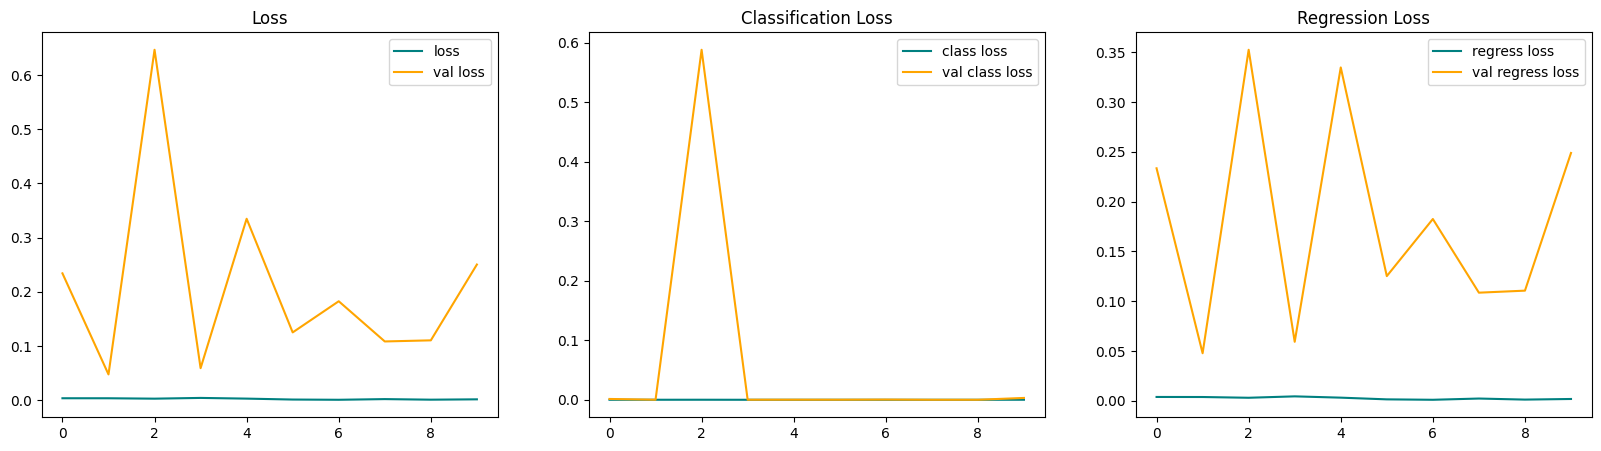

In [142]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# **11. Make Prediction**

## 11.1 Making Prediction on test set for valuation purpose

In [143]:
test_data = test.as_numpy_iterator()

In [150]:
test_sample = test_data.next()
test_sample

(array([[[[0.459375  , 0.5294118 , 0.46666667],
          [0.4678309 , 0.53186274, 0.47702205],
          [0.46844363, 0.5311887 , 0.48020834],
          ...,
          [0.3542892 , 0.36213234, 0.3425245 ],
          [0.24528186, 0.253125  , 0.23351716],
          [0.21476716, 0.2226103 , 0.20300245]],
 
         [[0.44607842, 0.5127451 , 0.45      ],
          [0.45159313, 0.5176471 , 0.45637256],
          [0.46623775, 0.5211397 , 0.47015932],
          ...,
          [0.41188726, 0.41580883, 0.39227942],
          [0.4507353 , 0.45465687, 0.43112746],
          [0.41378677, 0.41770834, 0.39417893]],
 
         [[0.4393995 , 0.49430147, 0.43547794],
          [0.45196077, 0.50686276, 0.4480392 ],
          [0.4636642 , 0.5185662 , 0.46758577],
          ...,
          [0.2720588 , 0.28382352, 0.25637254],
          [0.37003675, 0.37395832, 0.3504289 ],
          [0.43566176, 0.43958333, 0.41605392]],
 
         ...,
 
         [[0.16060048, 0.246875  , 0.29001224],
          [0.03443

In [157]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 377ms/step


In [158]:
yhat

[array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32),
 array([[4.1240412e-08, 4.9194195e-20, 7.8547224e-08, 9.9948788e-01],
        [9.9918824e-01, 1.5930028e-04, 1.0000000e+00, 1.0000000e+00],
        [4.0682199e-08, 8.5348052e-17, 5.2905658e-09, 9.9955815e-01],
        [9.9997699e-01, 2.1484312e-19, 9.9999273e-01, 9.9999988e-01],
        [1.0721853e-06, 8.5499539e-18, 6.1566825e-05, 1.0000000e+00],
        [5.3575076e-07, 5.9179086e-18, 1.8501213e-08, 9.3464220e-01],
        [1.1633052e-05, 9.6364688e-18, 1.5440191e-08, 9.9999964e-01],
        [9.9998987e-01, 4.8888581e-17, 9.9999237e-01, 9.9999797e-01]],
       dtype=float32)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


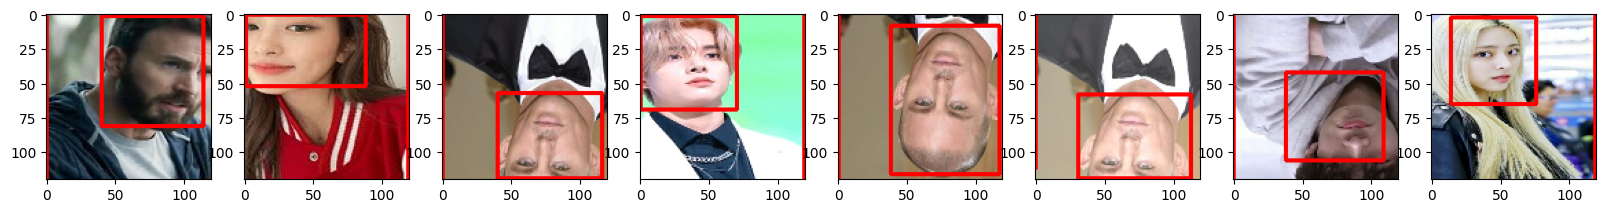

In [159]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx in range(8): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the model

In [156]:
#Model Speicherung
from tensorflow.keras.models import load_model

In [161]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [202]:
rtp_test = cv2.imread("producttest\olaf.jpeg")
resized = tf.image.resize(rtp_test, (120,120))


In [203]:
size = rtp_test.shape
size

(720, 1440, 3)

In [204]:
yhat = facetracker.predict(np.expand_dims(resized/255,0))


1/1 [==============================] - 0s 50ms/step


In [205]:
sample_coords = yhat[1][0]
sample_coords

array([0.2682853 , 0.26985687, 0.52557856, 0.8652316 ], dtype=float32)

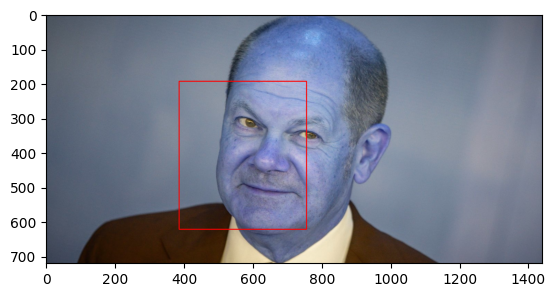

In [206]:
cv2.rectangle(rtp_test,
              tuple(np.multiply(sample_coords[:2], [size[1],size[0]]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [size[1],size[0]]).astype(int)),
              (255,0,0),2)
plt.imshow(rtp_test)